In [1]:
# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

In [2]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# number of input columns
n_inputs = X.shape[1]
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [9]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

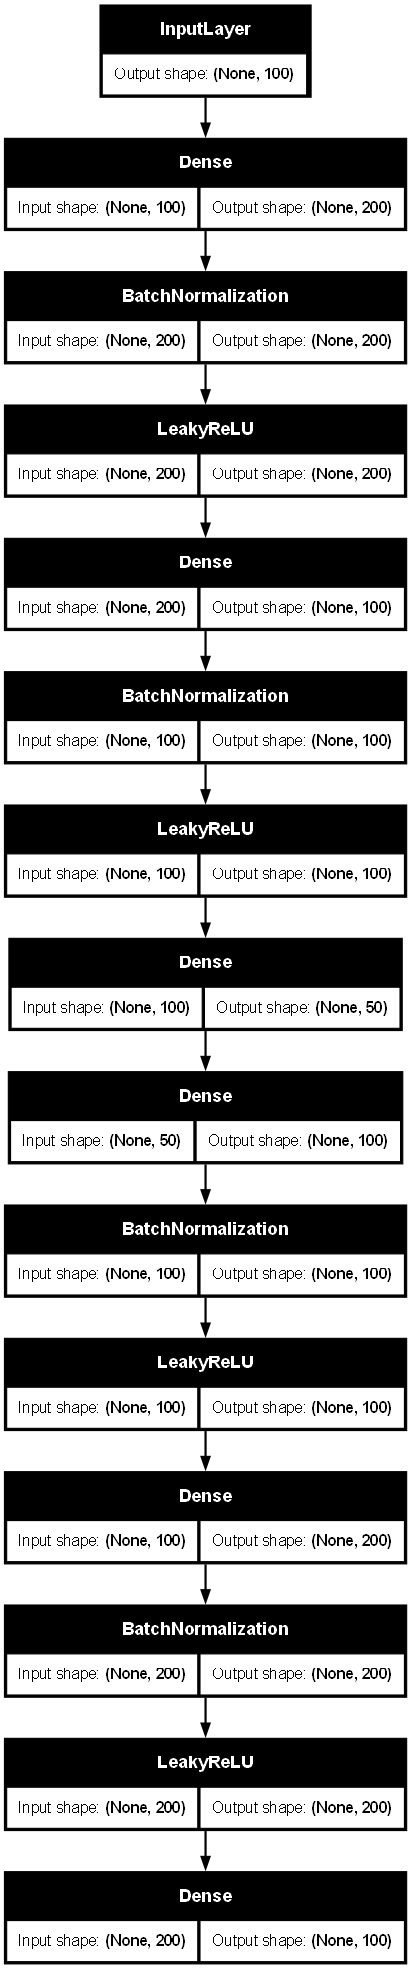

In [10]:
# plot the autoencoder
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True, dpi=80)

Epoch 1/200
42/42 - 4s - 87ms/step - loss: 0.2280 - val_loss: 0.1884
Epoch 2/200
42/42 - 0s - 3ms/step - loss: 0.0379 - val_loss: 0.1046
Epoch 3/200
42/42 - 0s - 4ms/step - loss: 0.0243 - val_loss: 0.0554
Epoch 4/200
42/42 - 0s - 3ms/step - loss: 0.0196 - val_loss: 0.0311
Epoch 5/200
42/42 - 0s - 3ms/step - loss: 0.0168 - val_loss: 0.0202
Epoch 6/200
42/42 - 0s - 3ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 7/200
42/42 - 0s - 3ms/step - loss: 0.0133 - val_loss: 0.0102
Epoch 8/200
42/42 - 0s - 3ms/step - loss: 0.0133 - val_loss: 0.0089
Epoch 9/200
42/42 - 0s - 4ms/step - loss: 0.0115 - val_loss: 0.0075
Epoch 10/200
42/42 - 0s - 3ms/step - loss: 0.0118 - val_loss: 0.0066
Epoch 11/200
42/42 - 0s - 4ms/step - loss: 0.0103 - val_loss: 0.0065
Epoch 12/200
42/42 - 0s - 3ms/step - loss: 0.0100 - val_loss: 0.0056
Epoch 13/200
42/42 - 0s - 3ms/step - loss: 0.0096 - val_loss: 0.0054
Epoch 14/200
42/42 - 0s - 3ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 15/200
42/42 - 0s - 3ms/step - loss:

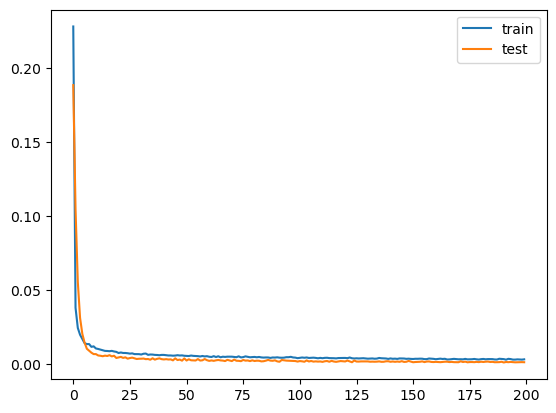

In [11]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

In [12]:
# baseline in performance with logistic regression model
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define model
model = LogisticRegression()
# fit model on training set
model.fit(X_train, y_train)
# make prediction on test set
yhat = model.predict(X_test)
# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.8939393939393939


In [19]:
# evaluate logistic regression on encoded input
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# load the model from file
encoder = load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(X_train_encode, y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
0.9393939393939394


C:\Users\SUHlab\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
